In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("final_df_merged.csv", low_memory=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69428 entries, 0 to 69427
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appid                69428 non-null  int64  
 1   name                 69428 non-null  object 
 2   metacritic           2933 non-null   float64
 3   steam_achievements   69428 non-null  bool   
 4   steam_trading_cards  69428 non-null  bool   
 5   workshop_support     69428 non-null  bool   
 6   genres               69324 non-null  object 
 7   achievements_total   37295 non-null  float64
 8   release_date         69426 non-null  object 
 9   supported_platforms  69428 non-null  object 
 10  has_dlc              69428 non-null  int64  
 11  has_demo             69428 non-null  int64  
 12  price                69428 non-null  float64
 13  copiesSold           69428 non-null  int64  
 14  publisherClass       69428 non-null  object 
 15  reviewScore          69428 non-null 

# **Appid si name**

In [ ]:
missing = df[["appid", "name"]].isna().sum()
print(missing)

appid    0
name     0
dtype: int64


In [ ]:
#Verificare duplicate
dup_appid = df["appid"].duplicated().sum()
dup_name = df["name"].duplicated().sum()

print("Duplicated appid:", dup_appid)
print("Duplicated name:", dup_name)

Duplicated appid: 1519
Duplicated name: 1897


In [ ]:
dups = df[df.duplicated(subset=["appid", "name"], keep=False)]
print(dups.to_string())

         appid                                                                                         name  metacritic  steam_achievements  steam_trading_cards  workshop_support                                                                                     genres  achievements_total     release_date          supported_platforms  has_dlc  has_demo   price  copiesSold publisherClass  reviewScore  aiContent     discount                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# toate rândurile duplicate după appid + name
dup = df[df.duplicated(subset=["appid", "name"], keep=False)]

# toate jocurile care apar de două ori sau mai mult
unique_dups = dup[["appid", "name"]].drop_duplicates()

print(unique_dups.to_string())


         appid                                                                                         name
21     3177130                                                                          Stock Exchange Game
22     3173440                                                                                   Doomwalker
23     3166850                                                                             Find Cats 3 旅行猫咪
24     3165320                                                                                  Playing God
25     3161520                                                                                   NecroWorld
26     3294880                                                                                         不安ごと
27     3295230                                                                                  Happy Hotel
28     3293470                                                                           Operation Blackfox
29     3292320              

In [ ]:
dups = df[df.duplicated(subset=["appid", "name"], keep=False)]

duplicate_counts = dups.groupby(["appid", "name"]).size().reset_index(name="duplicate_count")

print("Cate duplicate are fiecare joc:")
print(duplicate_counts)

columns_to_compare = ["steam_achievements", "steam_trading_cards", "workshop_support"]

print("\nDiferente in valorile duplicatelor pentru fiecare joc:")
for (appid, name), group in dups.groupby(["appid", "name"]):
    unique_rows = group[columns_to_compare].drop_duplicates()

    if len(unique_rows) > 1:
        print(f"\n{name} (appid {appid}):")
        print(unique_rows)


Streaming output truncated to the last 5000 lines.

Tesserarii (appid 3176790):
       steam_achievements  steam_trading_cards  workshop_support
2879                 True                 True              True
47265               False                False             False

Gridlink (appid 3176800):
       steam_achievements  steam_trading_cards  workshop_support
4373                 True                 True              True
47266                True                False             False

Drift On Snow (appid 3176820):
       steam_achievements  steam_trading_cards  workshop_support
2306                 True                 True              True
47267               False                False             False

Bricks of Camels (appid 3176940):
       steam_achievements  steam_trading_cards  workshop_support
5047                 True                 True              True
47249                True                False             False

じゅうにばんめにわるいゆめのさち (appid 3176950):
       stea

In [ ]:
import pandas as pd
import numpy as np
import ast
import re

df = pd.read_csv("final_df_merged.csv")

bool_cols = ["steam_achievements", "steam_trading_cards", "workshop_support"]
key_cols = ["appid", "name"]

def parse_os(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []

def os_count(x):
    return len(parse_os(x))

date_pattern = re.compile(r"^\d{1,2}-[A-Za-z]{3}-\d{2,4}$")
def is_real_date(x):
    x = str(x).strip()
    return bool(date_pattern.match(x))

rows_to_drop = set()
apps_to_delete = set()

dup_groups = df[df.duplicated(subset=key_cols, keep=False)].groupby(key_cols)

for (appid, name), g in dup_groups:

    bool_unique = g[bool_cols].drop_duplicates()

    if len(bool_unique) == 2 and \
       set(bool_unique.sum(axis=1)) == {0, 3}:
        apps_to_delete.add(appid)
        continue

    if len(g) == 1:
        continue

    g = g.copy()
    g["real_date"] = g["release_date"].apply(is_real_date)
    g["os_count"] = g["supported_platforms"].apply(os_count)
    g["bool_sum"] = g[bool_cols].sum(axis=1)

    g_sorted = g.sort_values(
        by=["real_date", "os_count", "bool_sum"],
        ascending=[False, True, True]
    )

    row_to_keep = g_sorted.index[0]
    rows_to_drop_for_group = set(g.index) - {row_to_keep}

    rows_to_drop.update(rows_to_drop_for_group)


df_clean = df.copy()
df_clean = df_clean[~df_clean["appid"].isin(apps_to_delete)]
df_clean = df_clean.drop(index=list(rows_to_drop))

df_clean.to_csv("df_appid.csv", index=False)

print("Deleted entire apps:", len(apps_to_delete))
print("Deleted individual duplicate rows:", len(rows_to_drop))
print("Final dataset size:", len(df_clean))


Deleted entire apps: 878
Deleted individual duplicate rows: 640
Final dataset size: 67032


Am sters toate duplicatele si inconsistentele dupa regulile:
1. Daca exista o duplicata are un release date, iar cealalta are Unreleased/Coming soon, o pastram pe cea cu data
2. Daca are inconsistente la genruile de joc, alegem jocul cu cele mai multe genuri de joc
3. Daca un joc are [windows, mac, linux], iar celalt are doar [windows], il stergem pe cel cu cele mai putine OS-uri


# **Metacritic**

In [ ]:
df = pd.read_csv("df_appid.csv", low_memory=False)

df["metacritic"] = df["metacritic"].astype(float)
df["metacritic"] = df["metacritic"].replace("", np.nan) #orinde e spatiu gol devine NaN
df["metacritic"] = df["metacritic"].where(df["metacritic"].notna(), np.nan)

df.to_csv("df_metacritic.csv", index=False)

/tmp/ipython-input-3814843842.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated["metacritic_interval"] = pd.cut(


Metacritic score intervals (number of games):

0: 0 games
1–10: 0 games
10–20: 1 games
20–30: 4 games
30–40: 20 games
40–50: 58 games
50–60: 217 games
60–70: 640 games
70–80: 1235 games
80–90: 702 games
90–100: 55 games

Unrated games (NaN): 64100


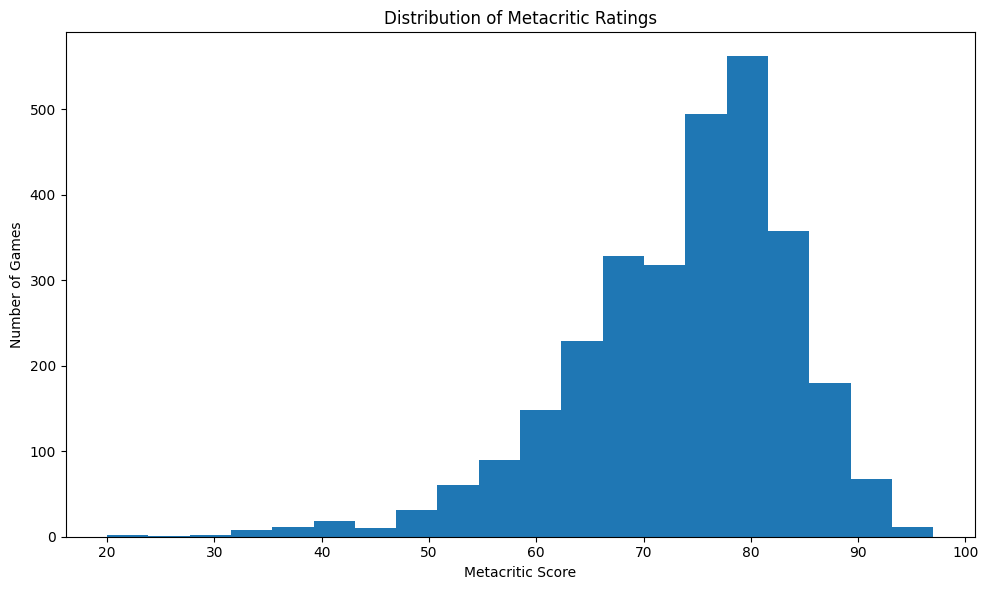

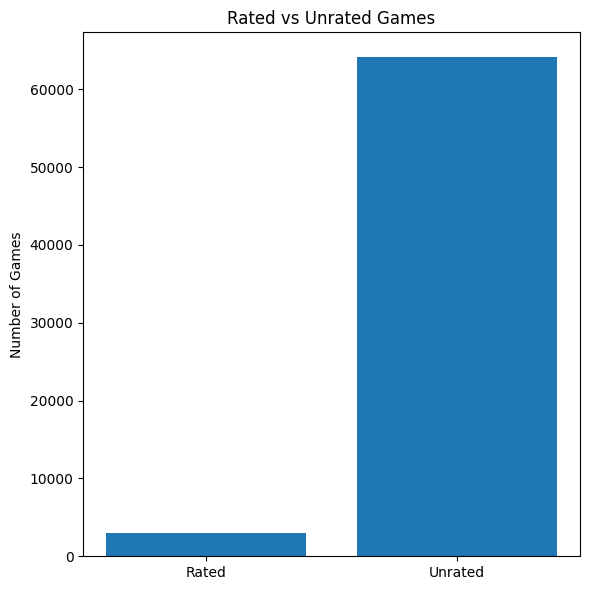

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("df_metacritic.csv", low_memory=False)

df["metacritic"] = pd.to_numeric(df["metacritic"], errors="coerce")

rated = df[df["metacritic"].notna()]
unrated_count = df["metacritic"].isna().sum()

#printed version
bins = [-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [
    "0",
    "1–10",
    "10–20",
    "20–30",
    "30–40",
    "40–50",
    "50–60",
    "60–70",
    "70–80",
    "80–90",
    "90–100"
]

rated["metacritic_interval"] = pd.cut(
    rated["metacritic"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

print("Metacritic score intervals (number of games):\n")
interval_counts = rated["metacritic_interval"].value_counts().sort_index()

for interval, count in interval_counts.items():
    print(f"{interval}: {count} games")

print(f"\nUnrated games (NaN): {unrated_count}")

#grafice
plt.figure(figsize=(10, 6))
plt.hist(rated["metacritic"], bins=20)
plt.xlabel("Metacritic Score")
plt.ylabel("Number of Games")
plt.title("Distribution of Metacritic Ratings")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.bar(["Rated", "Unrated"], [len(rated), unrated_count])
plt.ylabel("Number of Games")
plt.title("Rated vs Unrated Games")
plt.tight_layout()
plt.show()


Metacritic score distribution (5-point intervals):

0–5: 0 games
5–10: 0 games
10–15: 0 games
15–20: 1 games
20–25: 2 games
25–30: 2 games
30–35: 8 games
35–40: 12 games
40–45: 25 games
45–50: 33 games
50–55: 78 games
55–60: 139 games
60–65: 242 games
65–70: 398 games
70–75: 555 games
75–80: 680 games
80–85: 498 games
85–90: 204 games
90–95: 50 games
95–100: 5 games

Unrated games (NaN): 64100


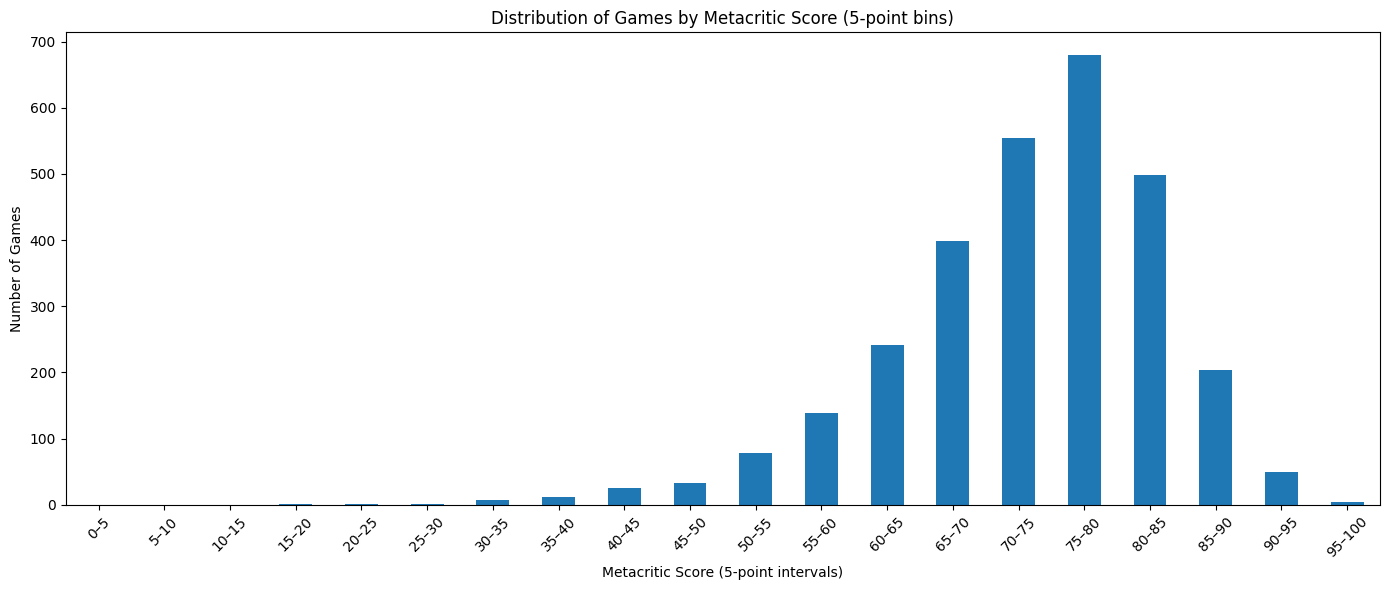

In [ ]:
rated = df[df["metacritic"].notna()].copy()
unrated_count = df["metacritic"].isna().sum()

bins = np.arange(0, 105, 5)
labels = [f"{i}–{i+5}" for i in range(0, 100, 5)]

rated["metacritic_5pt"] = pd.cut(
    rated["metacritic"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

interval_counts = rated["metacritic_5pt"].value_counts().sort_index()

print("Metacritic score distribution (5-point intervals):\n")
for interval, count in interval_counts.items():
    print(f"{interval}: {count} games")

print(f"\nUnrated games (NaN): {unrated_count}")


plt.figure(figsize=(14, 6))
interval_counts.plot(kind="bar")
plt.xlabel("Metacritic Score (5-point intervals)")
plt.ylabel("Number of Games")
plt.title("Distribution of Games by Metacritic Score (5-point bins)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("df_metacritic.csv", low_memory=False)

df["metacritic"] = pd.to_numeric(df["metacritic"], errors="coerce")

def categorize_metacritic(score):
    if pd.isna(score):
        return "Unrated"
    elif score > 85:
        return "Excellent"
    elif score >= 75:
        return "Good"
    elif score >= 65:
        return "Average"
    else:
        return "Poor"

df["metacritic_category"] = df["metacritic"].apply(categorize_metacritic)
df["metacritic_category"] = df["metacritic_category"].astype("object") #converts to object

Metacritic category distribution:

Unrated: 64100 games
Good: 1313 games
Average: 884 games
Poor: 476 games
Excellent: 259 games


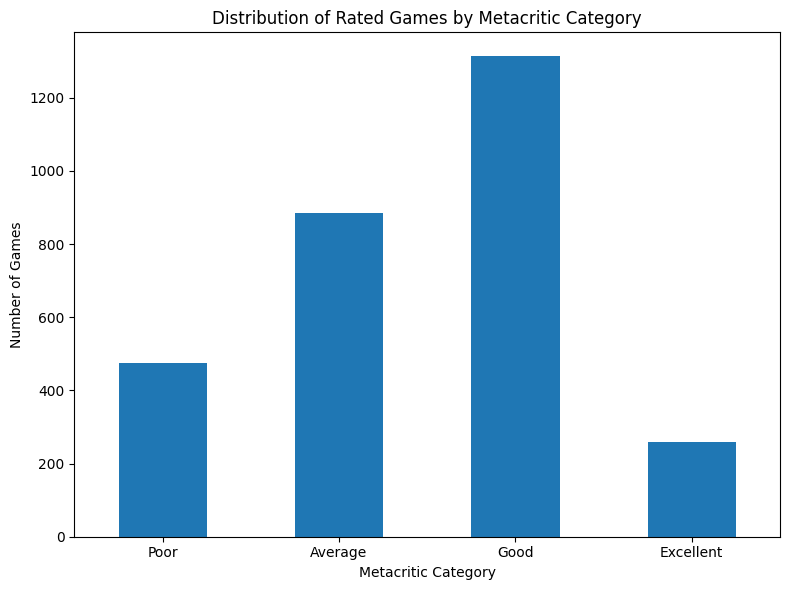

In [ ]:
category_counts = df["metacritic_category"].value_counts()

print("Metacritic category distribution:\n")
for category, count in category_counts.items():
    print(f"{category}: {count} games")

category_counts = df["metacritic_category"].value_counts()
rated_counts = category_counts.drop("Unrated", errors="ignore")
category_order = [
    "Poor",
    "Average",
    "Good",
    "Excellent"
]

df["metacritic_category"] = pd.Categorical(
    df["metacritic_category"],
    categories=["Unrated"] + category_order,
    ordered=True
)

category_counts = df["metacritic_category"].value_counts(sort=False)
rated_counts = category_counts.drop("Unrated", errors="ignore")

plt.figure(figsize=(8, 6))
rated_counts.plot(kind="bar")
plt.xlabel("Metacritic Category")
plt.ylabel("Number of Games")
plt.title("Distribution of Rated Games by Metacritic Category")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=["metacritic"])

In [ ]:
df.to_csv("df_metacritic_categorized.csv", index=False)

# **Steam_achievements**

Coloana Total_achievement este o coloana numerica care reprezinta cate achievementuri are jocul.

Este strans legata de coloana Steam_achievements este o coloana de tip bool care reprezinta daca exista sistemul de achievemnturi, chiar daca se poate sa nu fie niciun achievement existent.

Dar exista niste neconcordante, unde coloana Total_achievements > 0, iar Steam_achievements = FALSE.

De aceea vom elimina coloana Steam_achivements, fiindca ofera mai putin informatii decat Total_achievements.

In [ ]:
df = df.drop(columns=["steam_achievements"])
df.to_csv("df_steam_achievements.csv", index=False)

# **Steam Trading Cards**

In [ ]:
df = pd.read_csv("df_steam_achievements.csv", low_memory=False)

missing_cards = df["steam_trading_cards"].isna().sum()

print("Missing values in steam_trading_cards:", missing_cards)

Missing values in steam_trading_cards: 0


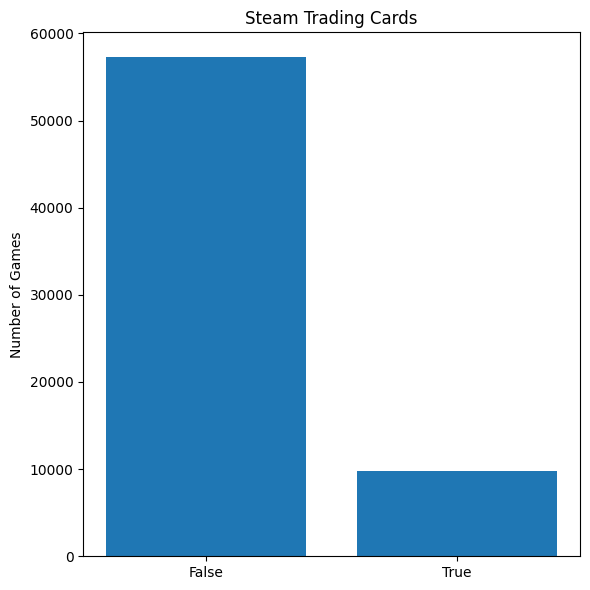

Games without trading cards: 57260
Games with trading cards: 9772


In [ ]:
counts = df["steam_trading_cards"].value_counts()

plt.figure(figsize=(6,6))
plt.bar(["False","True"], [counts.get(False,0), counts.get(True,0)])
plt.ylabel("Number of Games")
plt.title("Steam Trading Cards")
plt.tight_layout()
plt.show()

print("Games without trading cards:", counts.get(False, 0))
print("Games with trading cards:", counts.get(True, 0))

# **Workshop Support**

In [ ]:
missing_workshop_support = df["workshop_support"].isna().sum()

print("Missing values in workshop_support:", missing_workshop_support)

Missing values in workshop_support: 0


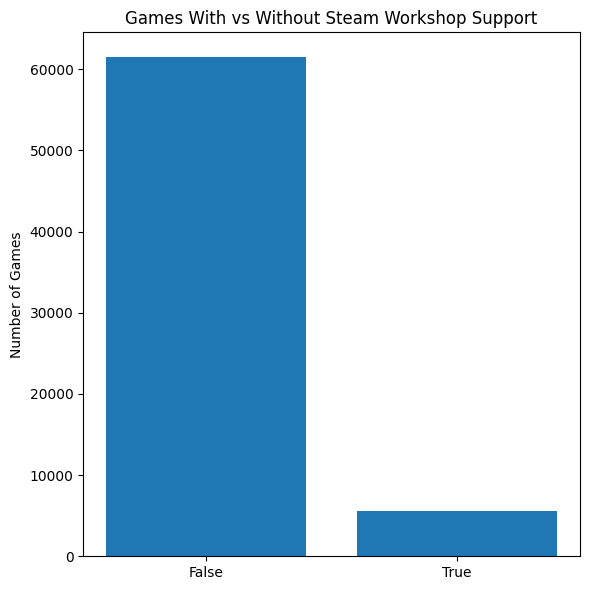

Games without workshop support: 61475
Games with workshop support: 5557


In [ ]:
counts = df["workshop_support"].value_counts()

plt.figure(figsize=(6,6))
plt.bar(["False","True"], [counts.get(False,0), counts.get(True,0)])
plt.ylabel("Number of Games")
plt.title("Games With vs Without Steam Workshop Support")
plt.tight_layout()
plt.show()

print("Games without workshop support:", counts.get(False, 0))
print("Games with workshop support:", counts.get(True, 0))


# **Achievements_total**

In [ ]:
missing_count = df["steam_trading_cards"].isna().sum()

print("Missing values in steam_achievements:", missing_count)

Missing values in steam_achievements: 0


In [ ]:
df["achievements_total"] = pd.to_numeric(df["achievements_total"], errors="coerce").fillna(0)

zero_count = (df["achievements_total"] == 0).sum()

print("Games with 0 achievements:", zero_count)

Games with 0 achievements: 31128


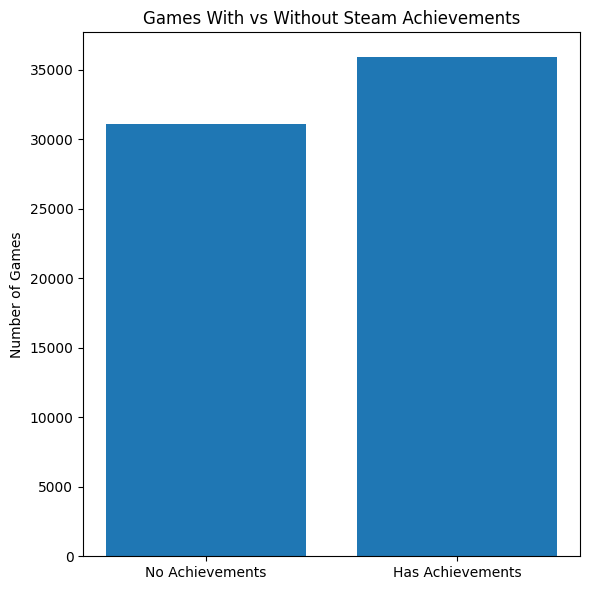

In [ ]:
df["achievements_total"] = pd.to_numeric(df["achievements_total"], errors="coerce").fillna(0)

with_ach = (df["achievements_total"] > 0).sum()

no_ach = (df["achievements_total"] == 0).sum()

plt.figure(figsize=(6,6))
plt.bar(["No Achievements", "Has Achievements"], [no_ach, with_ach])
plt.ylabel("Number of Games")
plt.title("Games With vs Without Steam Achievements")
plt.tight_layout()
plt.show()


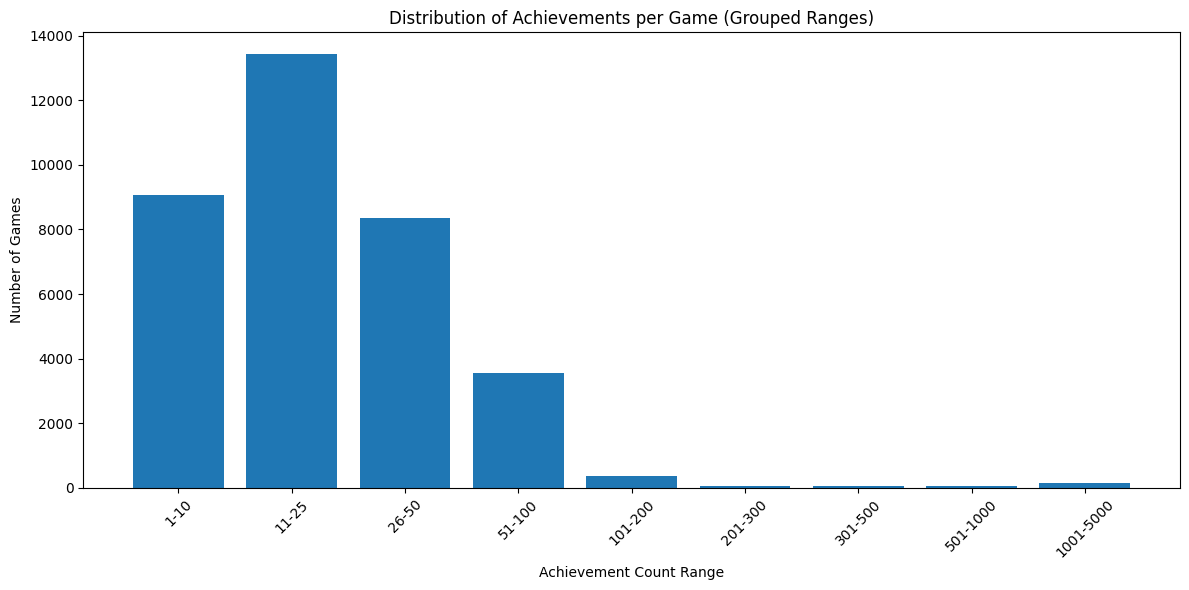

In [ ]:
ach = df[df["achievements_total"] > 0]["achievements_total"]

bins = [1, 10, 25, 50, 100, 200, 300, 500, 1000, 5000]
labels = [
    "1-10", "11-25", "26-50", "51-100", "101-200",
    "201-300", "301-500", "501-1000", "1001-5000"
]

ach_binned = pd.cut(ach, bins=bins, labels=labels, right=True)

counts = ach_binned.value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Achievement Count Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Achievements per Game (Grouped Ranges)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Zero: 31128 games
Very Low: 9880 games
Low: 10142 games
Medium: 7831 games
High: 8051 games


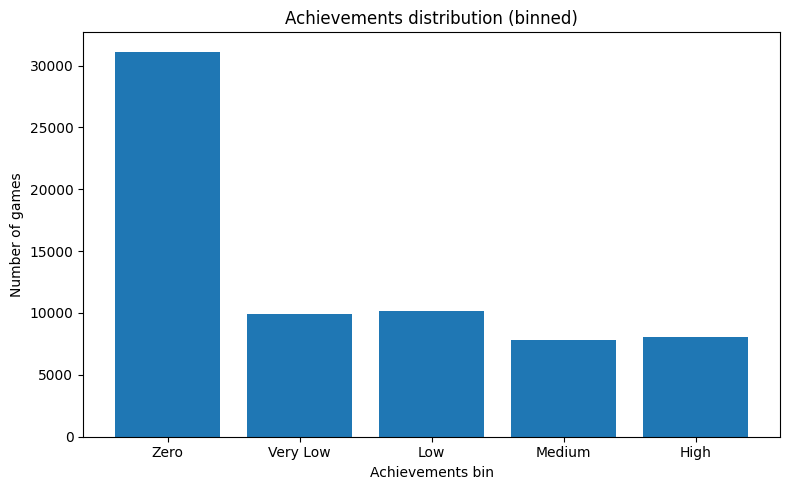

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df["achievements_total"] = pd.to_numeric(df["achievements_total"], errors="coerce")

zero_mask = df["achievements_total"].isna() | (df["achievements_total"] == 0)

bins = [0, 10, 20, 35, np.inf]
labels = ["Very Low", "Low", "Medium", "High"]

df["achievements_bin"] = "Zero"
df.loc[~zero_mask, "achievements_bin"] = pd.cut(
    df.loc[~zero_mask, "achievements_total"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=False
).astype(str)

order = ["Zero"] + labels
counts = df["achievements_bin"].value_counts().reindex(order, fill_value=0)

for k, v in counts.items():
    print(f"{k}: {int(v)} games")

plt.figure(figsize=(8, 5))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Achievements bin")
plt.ylabel("Number of games")
plt.title("Achievements distribution (binned)")
plt.tight_layout()
plt.show()

df.to_csv("df_achievements_binned.csv", index=False)


In [ ]:
df.drop(columns="achievements_total")

appid                      name  steam_trading_cards  \
0      2574000            Femboy Burgers                 True   
1      2574120  PPA Pickleball Tour 2025                 True   
2      2573200             Squeaky Squad                 True   
3      2569520    Naturpark Lillebælt VR                 True   
4      2567670            A Lively Haunt                 True   
...        ...                       ...                  ...   
67027  3478030                 Retr0Mine                False   
67028  1465460       Infection Free Zone                False   
67029  2999030      Exploding Kittens® 2                False   
67030  1548850      Six Days in Fallujah                False   
67031  1335700          Marbleous Blocks                False   

       workshop_support                                             genres  \
0                  True                                      Casual, Indie   
1                  True                          Indie, Simulation, Sports   
2                  True                           Action, Adventure, Indie   
3                  True                                  Action, Adventure   
4                  True                                   Adventure, Indie   
...                 ...                                                ...   
67027             False                                           Strategy   
67028              True  Action, Indie, Simulation, Strategy, Early Access   
67029             False        Action, Casual, Indie, Simulation, Strategy   
67030             False                               Action, Early Access   
67031             False                                              Indie   

      release_date          supported_platforms  has_dlc  has_demo  price  \
0        09-Oct-23  ['windows', 'mac', 'linux']        0         0  19.99   
1        16-Jul-24  ['windows', 'mac', 'linux']        0         0  29.99   
2        29-Mar-24  ['windows', 'mac', 'linux']        0         0   0.00   
3        18-Sep-23  ['windows', 'mac', 'linux']        0         0   0.00   
4        07-Sep-23  ['windows', 'mac', 'linux']        0         0   9.99   
...            ...                          ...      ...       ...    ...   
67027    09-Feb-25         ['windows', 'linux']        0         0   1.59   
67028    11-Apr-24                  ['windows']        0         1  24.99   
67029    12-Aug-24                  ['windows']        0         0  12.49   
67030    22-Jun-23                  ['windows']        0         0  39.99   
67031    27-Jan-21                  ['windows']        0         1   6.99   

       copiesSold publisherClass  reviewScore  aiContent     discount  \
0            1727          Indie           88        NaN  No discount   
1             367          Indie           38        NaN  No discount   
2            1298       Hobbyist           82        NaN  No discount   
3              65       Hobbyist           75        NaN  No discount   
4              47          Indie          100        NaN  No discount   
...           ...            ...          ...        ...          ...   
67027          72       Hobbyist          100        NaN  No discount   
67028      647531          Indie           79        NaN          -9%   
67029        7749          Indie           72        NaN         -50%   
67030      633920          Indie           83        NaN  No discount   
67031          48       Hobbyist           71        NaN  No discount   

                                               languages  positive_reviews  \
0                                                 ['[]']               129   
1                                            ['English']                 7   
2                                            ['English']                32   
3                                  ['English', 'Danish']                 3   
4                                            ['English']                 4   
...                  

In [ ]:
df.to_csv("df_intermediate.csv", index=False)

# **Release Date**

In [ ]:
df = pd.read_csv("df_intermediate.csv", low_memory=False)

In [ ]:
df["release_raw"] = df["release_date"].astype(str)

placeholders = [
    "Coming soon", "coming soon", "Coming Soon",
    "To be announced", "to be announced", "To be Announced",
    "TBA", "tba"
]

df["is_placeholder"] = df["release_raw"].isin(placeholders)

df["release_parsed"] = pd.NaT
formats = ["%d-%b-%y", "%d-%b-%Y", "%d-%m-%Y", "%Y"]

for fmt in formats:
    mask = df["release_parsed"].isna() & ~df["is_placeholder"]
    df.loc[mask, "release_parsed"] = pd.to_datetime(
        df.loc[mask, "release_raw"], format=fmt, errors="coerce"
    )

mask = df["release_parsed"].isna() & ~df["is_placeholder"]
df.loc[mask, "release_parsed"] = pd.to_datetime(
    df.loc[mask, "release_raw"], errors="coerce"
)

future_date = pd.Timestamp("2100-01-01")
df.loc[df["is_placeholder"], "release_parsed"] = future_date

today = pd.Timestamp.today().normalize()

def classify_release(dt):
    if pd.isna(dt):
        return "Unknown"
    if dt > today:
        return "Planned"
    return "Released"

df["release_status"] = df["release_parsed"].apply(classify_release)

df.to_csv("df_release_step1_normalized.csv", index=False)

/tmp/ipython-input-1297950052.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.loc[mask, "release_parsed"] = pd.to_datetime(


In [ ]:
df = pd.read_csv("df_release_step1_normalized.csv", low_memory=False)

today = pd.Timestamp.today().normalize()

def compute_days(row):
    status = row["release_status"]
    date = row["release_parsed"]

    if status in ["Unknown", "Planned"]:
        return np.nan

    return (today - pd.to_datetime(date)).days

df["days_since_release"] = df.apply(compute_days, axis=1)

df.to_csv("df_release_step2_days.csv", index=False)

In [ ]:
df = pd.read_csv("df_release_step2_days.csv", low_memory=False)

df["date_released"] = (df["release_status"] == "Released")
df["date_planned"] = (df["release_status"] == "Planned")
df["date_unknown"] = (df["release_status"] == "Unknown")

df.to_csv("df_release_step3_booleans.csv", index=False)

In [ ]:
df = pd.read_csv("df_release_step3_booleans.csv", low_memory=False)

counts = df["release_status"].value_counts().reindex(
    ["Released", "Planned", "Unknown"], fill_value=0
)
print(counts)

release_status
Released    66140
Planned       531
Unknown       361
Name: count, dtype: int64


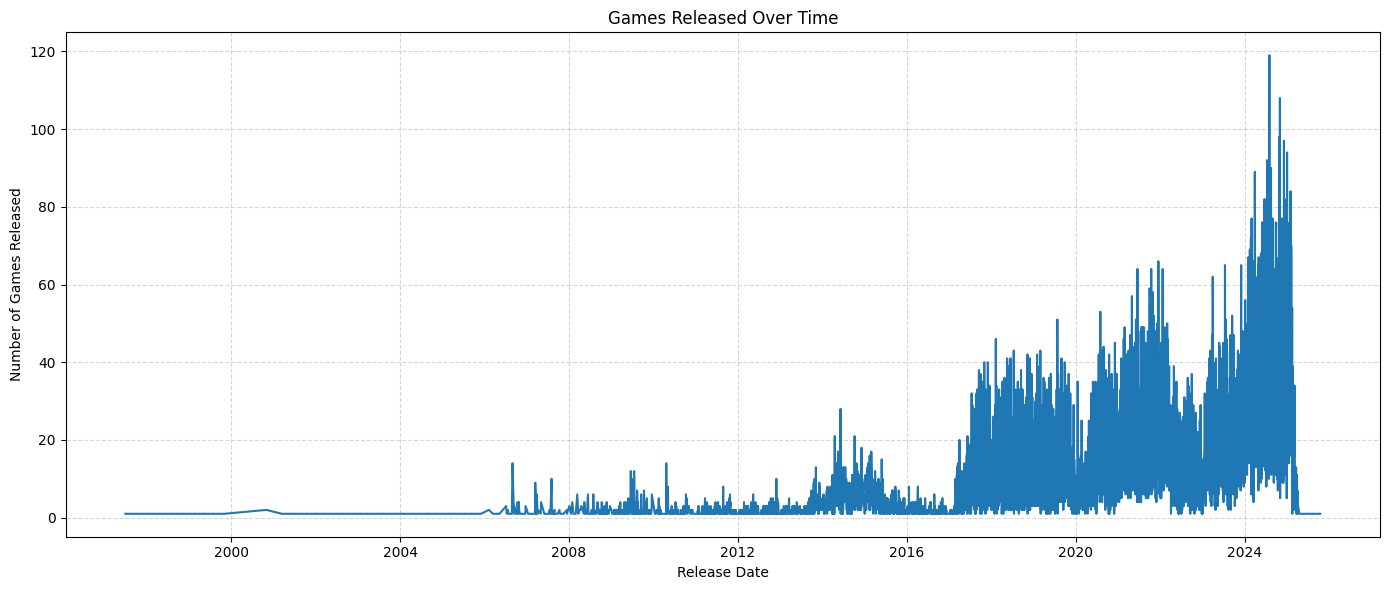

In [ ]:
import matplotlib.pyplot as plt

released_df = df[df["release_status"] == "Released"].copy()

released_df["release_parsed"] = pd.to_datetime(released_df["release_parsed"], errors="coerce")

daily_counts = released_df.groupby("release_parsed").size()

plt.figure(figsize=(14,6))
plt.plot(daily_counts.index, daily_counts.values)
plt.xlabel("Release Date")
plt.ylabel("Number of Games Released")
plt.title("Games Released Over Time")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

date_bins
Before_2008             160
Years_2008_to_2012     1127
Years_2013_to_2016     3316
Years_2017_to_2019    15953
Years_2020_to_2022    20573
From_2023_Onward      25011
Unreleased              892
Name: count, dtype: int64


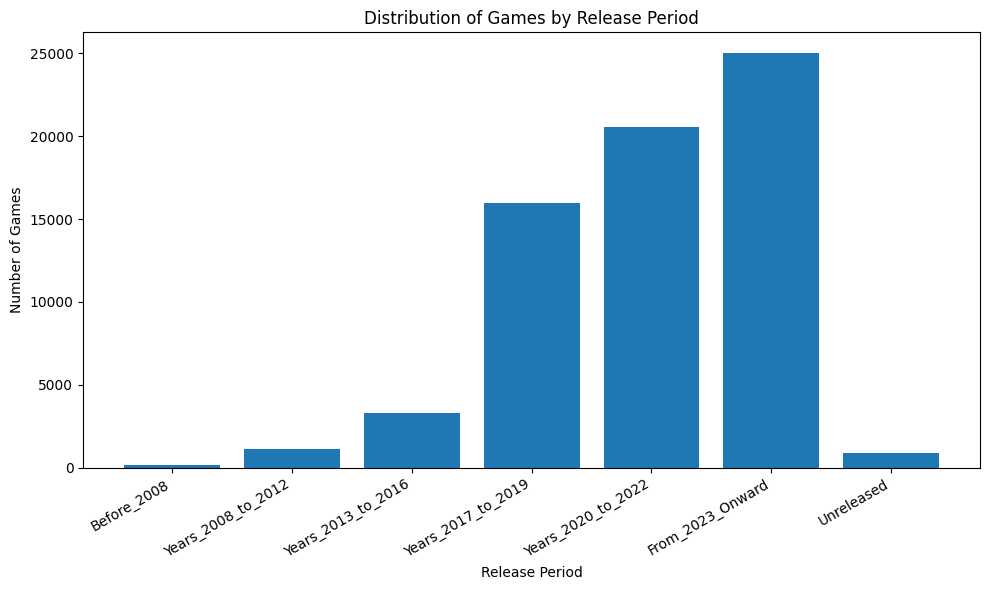

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df["release_parsed"] = pd.to_datetime(df["release_parsed"], errors="coerce")
today = pd.Timestamp.today().normalize()

labels = [
    "Before_2008",
    "Years_2008_to_2012",
    "Years_2013_to_2016",
    "Years_2017_to_2019",
    "Years_2020_to_2022",
    "From_2023_Onward"
]

bins = [
    pd.Timestamp.min,
    pd.Timestamp("2007-12-31"),
    pd.Timestamp("2012-12-31"),
    pd.Timestamp("2016-12-31"),
    pd.Timestamp("2019-12-31"),
    pd.Timestamp("2022-12-31"),
    today
]

df["date_bins"] = pd.cut(df["release_parsed"], bins=bins, labels=labels, include_lowest=True)

# merge Unreleased + Unknown + Planned into one bucket
df["date_bins"] = df["date_bins"].cat.add_categories("Unreleased")
unreleased_mask = df["release_status"].isin(["Unreleased", "Unknown", "Planned"]) | df["release_parsed"].isna()
df.loc[unreleased_mask, "date_bins"] = "Unreleased"

date_counts = df["date_bins"].value_counts().reindex(labels + ["Unreleased"], fill_value=0)
print(date_counts)

plt.figure(figsize=(10, 6))
plt.bar(date_counts.index.astype(str), date_counts.values)
plt.xlabel("Release Period")
plt.ylabel("Number of Games")
plt.title("Distribution of Games by Release Period")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

df.to_csv("df_release_step4_date_bins.csv", index=False)


In [ ]:
df = df.drop(columns=["release_date"])
df = df.drop(columns=["date_released"])
df = df.drop(columns=["date_planned"])
df = df.drop(columns=["date_unknown"])
df = df.drop(columns=["release_raw"])
df = df.drop(columns=["is_placeholder"])

In [ ]:
df = df.drop(columns=["release_status", "days_since_release"])

In [ ]:
df.to_csv("df_release_date.csv", index=False)

# **Supported Platforms**

In [ ]:
import ast

def parse_platforms(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except:
        return []

df["hasWindows"] = df["supported_platforms"].apply(lambda x: "windows" in [p.lower() for p in parse_platforms(x)])
df["hasMac"] = df["supported_platforms"].apply(lambda x: "mac" in [p.lower() for p in parse_platforms(x)])
df["hasLinux"] = df["supported_platforms"].apply(lambda x: "linux" in [p.lower() for p in parse_platforms(x)])


In [ ]:
df = df.drop(columns=["supported_platforms"])

In [ ]:
df.to_csv("df_supported_platforms.csv", index=False)

In [ ]:
df = pd.read_csv("df_supported_platforms.csv", low_memory=False)

# Count single platforms
count_windows = df["hasWindows"].sum()
count_mac = df["hasMac"].sum()
count_linux = df["hasLinux"].sum()

print("Windows only:", count_windows)
print("Mac only:", count_mac)
print("Linux only:", count_linux)

# Count combos of 2 platforms
count_win_mac = df[(df["hasWindows"]) & (df["hasMac"]) & (~df["hasLinux"])].shape[0]
count_win_linux = df[(df["hasWindows"]) & (~df["hasMac"]) & (df["hasLinux"])].shape[0]
count_mac_linux = df[(~df["hasWindows"]) & (df["hasMac"]) & (df["hasLinux"])].shape[0]

print("Windows + Mac only:", count_win_mac)
print("Windows + Linux only:", count_win_linux)
print("Mac + Linux only:", count_mac_linux)

# Count all 3
count_all_three = df[(df["hasWindows"]) & (df["hasMac"]) & (df["hasLinux"])].shape[0]

print("All Three (Windows + Mac + Linux):", count_all_three)


Windows only: 67024
Mac only: 16083
Linux only: 12681
Windows + Mac only: 5681
Windows + Linux only: 2284
Mac + Linux only: 1
All Three (Windows + Mac + Linux): 10395


In [ ]:
import pandas as pd

df = pd.read_csv("df_supported_platforms.csv", low_memory=False)

outlier = df[
    (df["hasWindows"] == False) &
    (df["hasMac"] == True) &
    (df["hasLinux"] == True)
]

print(outlier[["appid", "name", "hasWindows", "hasMac", "hasLinux"]])
print("Number of games with no supported platforms:", len(outlier))


        appid                              name  hasWindows  hasMac  hasLinux
20333  594550  Arma: Cold War Assault Mac/Linux       False    True      True
Number of games with no supported platforms: 1


In [ ]:
df = df[df["appid"] != 594550]

df.to_csv("df_supported_platforms.csv", index=False)

am renuntat la un outlier care are doar max si linux ca sistem de operare.

# **Has DLC**

In [ ]:
import pandas as pd

df = pd.read_csv("df_supported_platforms.csv", low_memory=False)

missing = df["has_dlc"].isna().sum()

print("Missing values in has_dlc:", missing)

Missing values in has_dlc: 0


In [ ]:
df["has_dlc"] = df["has_dlc"].replace({0: False, 1: True}).astype(bool)

/tmp/ipython-input-277724467.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["has_dlc"] = df["has_dlc"].replace({0: False, 1: True}).astype(bool)


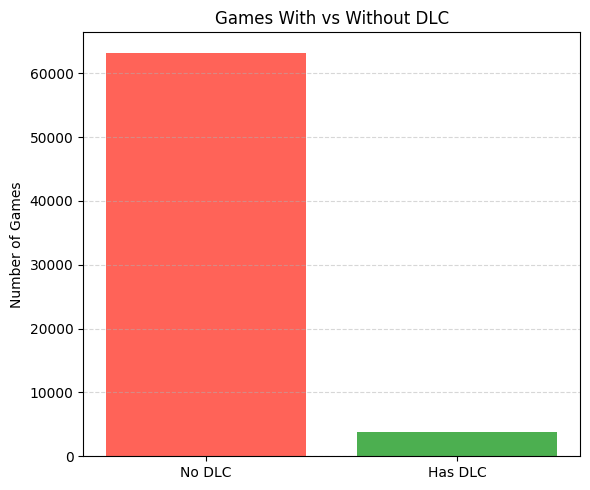

In [ ]:
df["has_dlc"] = df["has_dlc"].astype(bool)

dlc_counts = df["has_dlc"].value_counts().reindex([False, True], fill_value=0)

plt.figure(figsize=(6,5))
plt.bar(["No DLC", "Has DLC"], dlc_counts.values, color=["#FF6358", "#4CAF50"])
plt.ylabel("Number of Games")
plt.title("Games With vs Without DLC")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **Has Demo**

In [ ]:
missing = df["has_demo"].isna().sum()

print("Missing values in has_demo:", missing)

Missing values in has_demo: 0


In [ ]:
df["has_demo"] = df["has_demo"].replace({0: False, 1: True}).astype(bool)

/tmp/ipython-input-2988415141.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["has_demo"] = df["has_demo"].replace({0: False, 1: True}).astype(bool)


In [ ]:
df.to_csv("df_has_dlc_demo.csv", index=False)

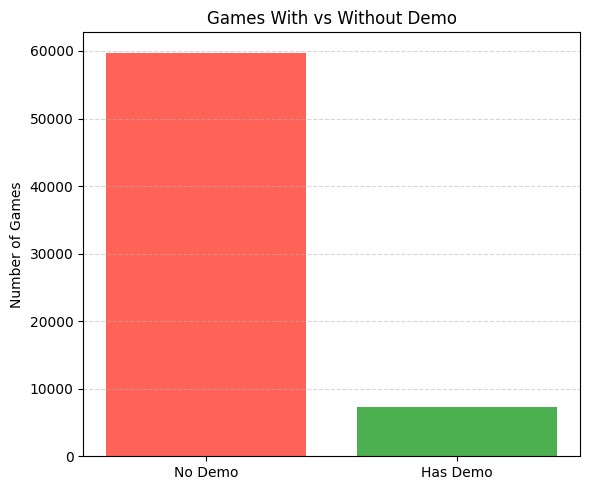

In [ ]:
df["has_demo"] = df["has_demo"].astype(bool)

demo_counts = df["has_demo"].value_counts().reindex([False, True], fill_value=0)

plt.figure(figsize=(6,5))
plt.bar(["No Demo", "Has Demo"], demo_counts.values, color=["#FF6358", "#4CAF50"])
plt.ylabel("Number of Games")
plt.title("Games With vs Without Demo")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **Price**

In [ ]:
df = pd.read_csv("df_has_dlc_demo.csv", low_memory=False)

missing_price = df["price"].isna().sum()

print("Missing values in price:", missing_price)

Missing values in price: 0


In [ ]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["price"] = df["price"].round(2)
df["price"] = df["price"].apply(lambda x: f"{x:.2f}" if pd.notna(x) else np.nan)

df.to_csv("df_price_cleaned.csv", index=False)

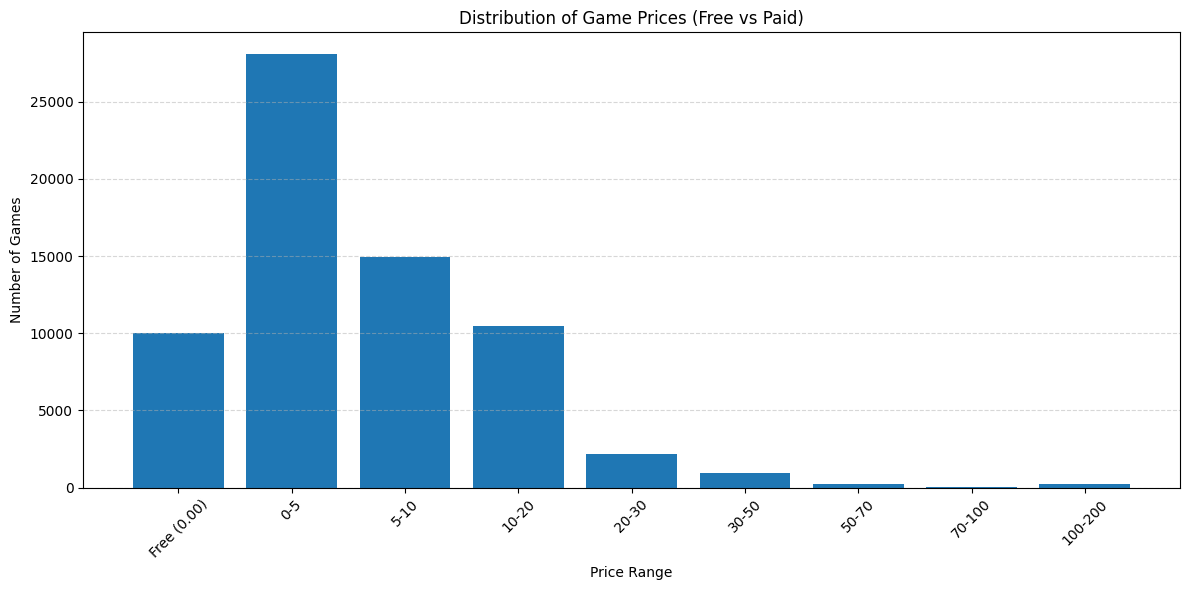

In [ ]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")
free_count = (df["price"] == 0).sum()
paid = df[df["price"] > 0]["price"]
bins = [0, 5, 10, 20, 30, 50, 70, 100, 200]
labels = ["0-5", "5-10", "10-20", "20-30", "30-50", "50-70", "70-100", "100-200"]

paid_binned = pd.cut(paid, bins=bins, labels=labels, right=True)
paid_counts = paid_binned.value_counts().sort_index()

bar_labels = ["Free (0.00)"] + labels
bar_values = [free_count] + list(paid_counts.values)

plt.figure(figsize=(12,6))
plt.bar(bar_labels, bar_values)
plt.xlabel("Price Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Game Prices (Free vs Paid)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **Publisher Class**

In [ ]:
missing_publishers = df["publisherClass"].isna().sum()

print("Missing values in publisherClass:", missing_publishers)

Missing values in publisherClass: 0


In [ ]:
unique_publishers = df["publisherClass"].dropna().unique()

print(unique_publishers)
print("\nNumber of unique publisher classes:", len(unique_publishers))


['Indie' 'Hobbyist' 'AA' 'AAA']

Number of unique publisher classes: 4


publisherClass
Hobbyist    37694
Indie       26373
AA           2161
AAA           803
Name: count, dtype: int64


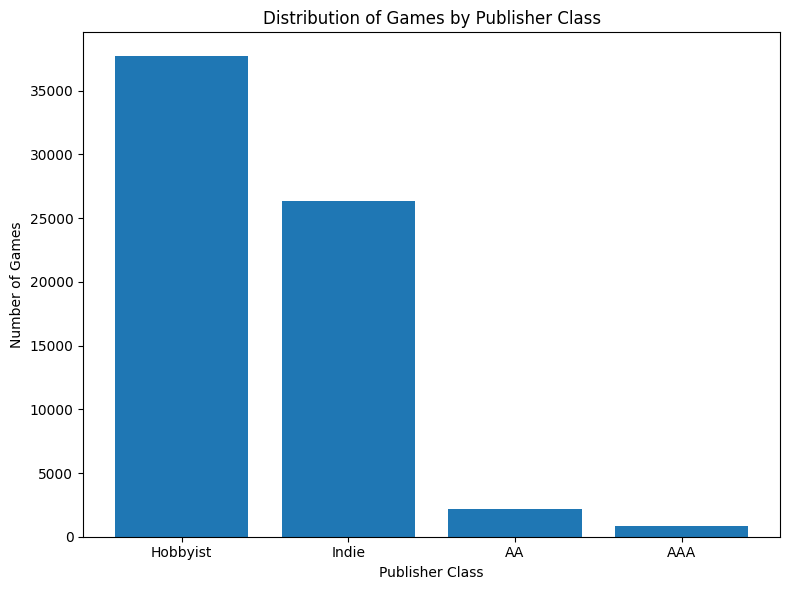

In [ ]:
classes = ["Hobbyist", "Indie", "AA", "AAA"]

publisher_counts = (
    df["publisherClass"]
    .value_counts()
    .reindex(classes, fill_value=0)
)

print(publisher_counts)

plt.figure(figsize=(8,6))
plt.bar(publisher_counts.index, publisher_counts.values)
plt.xlabel("Publisher Class")
plt.ylabel("Number of Games")
plt.title("Distribution of Games by Publisher Class")
plt.tight_layout()
plt.show()


In [ ]:
classes = ["Hobbyist", "Indie", "AA", "AAA"]

publisher_counts = (
    df["publisherClass"]
    .value_counts()
    .reindex(classes, fill_value=0)
)

for cls, count in publisher_counts.items():
    print(f"{cls}: {count}")

Hobbyist: 37694
Indie: 26373
AA: 2161
AAA: 803


# **Review Score**

In [ ]:
missing_review = df["reviewScore"].isna().sum()

print("Missing values in reviewScore:", missing_review)

Missing values in reviewScore: 0


In [ ]:
df["reviewScore"] = pd.to_numeric(df["reviewScore"], errors="coerce")

invalid = df[
    (df["reviewScore"].isna()) |
    (df["reviewScore"] < 0) |
    (df["reviewScore"] > 100) |
    (df["reviewScore"] % 1 != 0)
]

print("Number of invalid reviewScore entries:", len(invalid))
print(invalid[["appid", "name", "reviewScore"]].head(20))

Number of invalid reviewScore entries: 0
Empty DataFrame
Columns: [appid, name, reviewScore]
Index: []


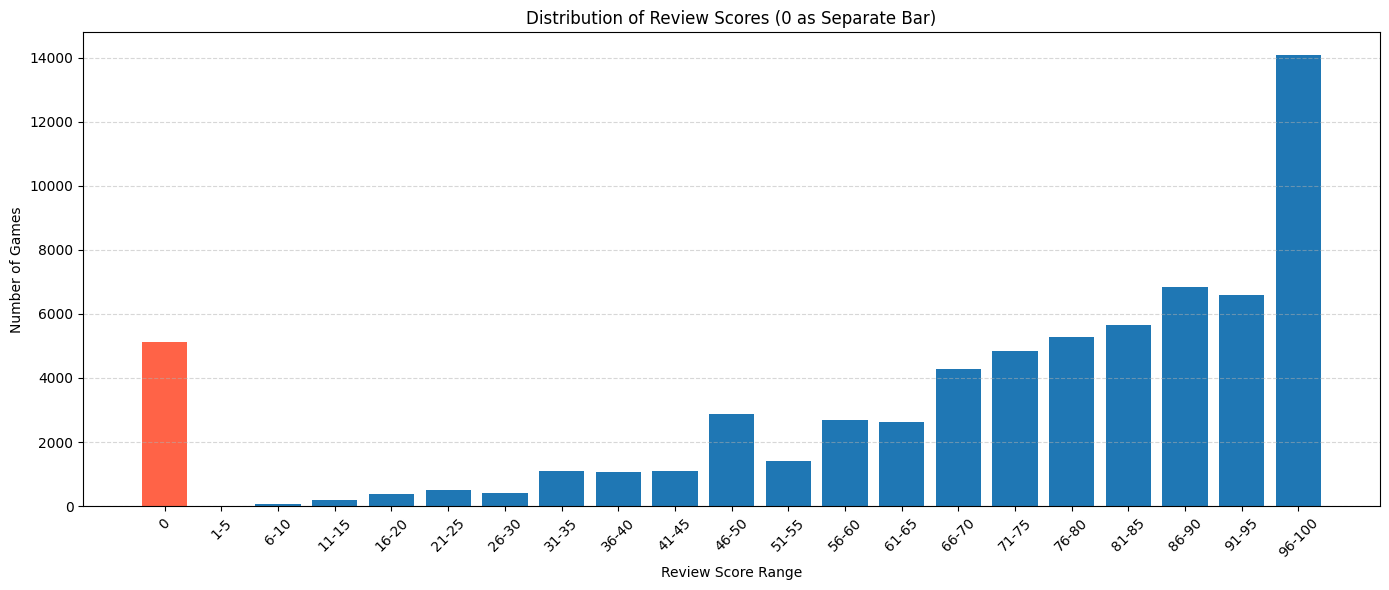

In [ ]:
df["reviewScore"] = pd.to_numeric(df["reviewScore"], errors="coerce")

zero_scores = (df["reviewScore"] == 0).sum()

nonzero = df[df["reviewScore"] > 0]["reviewScore"]

bins = list(range(1, 101, 5))
labels = [f"{i}-{i+4}" for i in bins]

nonzero_binned = pd.cut(nonzero, bins=bins+[101], labels=labels, right=False)
nonzero_counts = nonzero_binned.value_counts().sort_index()

plt.figure(figsize=(14,6))

plt.bar(["0"], [zero_scores], color="#FF6347")

plt.bar(labels, nonzero_counts.values)

plt.xlabel("Review Score Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Review Scores (0 as Separate Bar)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


reviewScore_bin
Very Low      9927
Low          13848
Good         15749
Very Good    13424
Excellent    14083
Name: count, dtype: int64


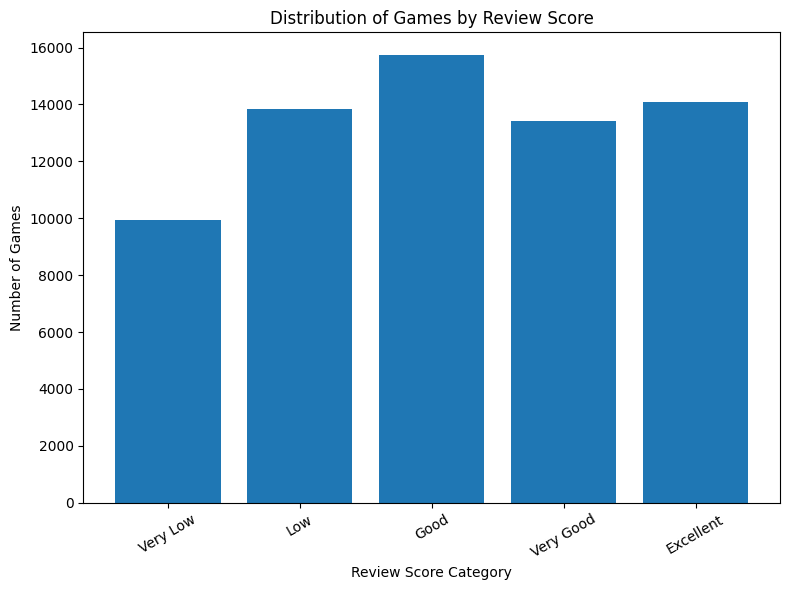

In [ ]:
labels = [
    "Very Low",
    "Low",
    "Good",
    "Very Good",
    "Excellent"
]

bins = [0, 45, 70, 85, 95, 100]

df["reviewScore_bin"] = pd.cut(
    df["reviewScore"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

score_counts = (
    df["reviewScore_bin"]
    .value_counts()
    .reindex(labels, fill_value=0)
)

print(score_counts)

plt.figure(figsize=(8,6))
plt.bar(score_counts.index.astype(str), score_counts.values)
plt.xlabel("Review Score Category")
plt.ylabel("Number of Games")
plt.title("Distribution of Games by Review Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=["reviewScore"])

In [ ]:
df.to_csv("df_reviewScore_bins.csv", index=False)

# **AI Content**

Toate inregistrarile sunt goale. Eliminam coloana

In [ ]:
df = df.drop(columns=["aiContent"])

# **Discount**

In [ ]:
def clean_discount(x):
    if pd.isna(x):
        return 0
    x = str(x).strip()
    if x.lower() == "no discount":
        return 0
    if x.endswith("%"):
        try:
            return abs(int(x.replace("%", "").replace("-", "")))
        except:
            return 0
    try:
        return int(x)
    except:
        return 0

df["discount"] = df["discount"].apply(clean_discount).astype(int)

df["discount"] = df["discount"].clip(0, 100)

df.to_csv("df_discount_cleaned.csv", index=False)


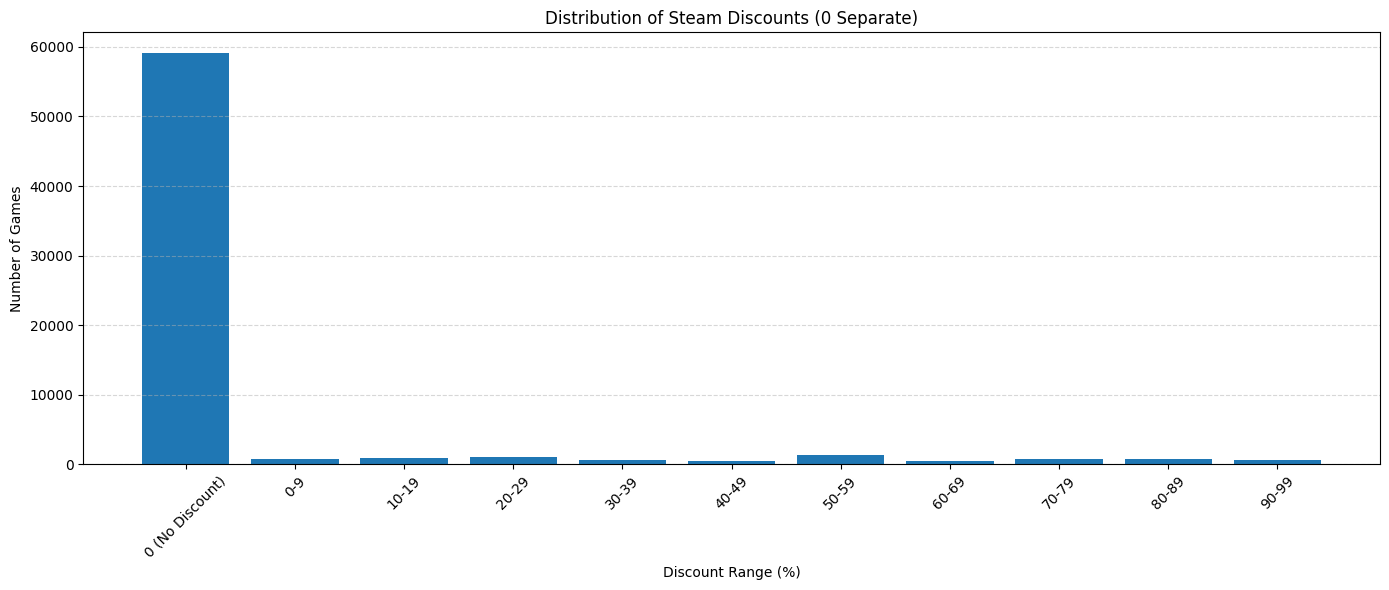

In [ ]:
df["discount"] = pd.to_numeric(df["discount"], errors="coerce").fillna(0).astype(int)

zero_count = (df["discount"] == 0).sum()

nonzero = df[df["discount"] > 0]["discount"]

bins = list(range(0, 101, 10))
labels = [f"{i}-{i+9}" for i in bins[:-1]]

nonzero_binned = pd.cut(nonzero, bins=bins, labels=labels, right=False)
nonzero_counts = nonzero_binned.value_counts().sort_index()

bar_labels = ["0 (No Discount)"] + labels
bar_values = [zero_count] + list(nonzero_counts.values)

plt.figure(figsize=(14,6))
plt.bar(bar_labels, bar_values)
plt.xlabel("Discount Range (%)")
plt.ylabel("Number of Games")
plt.title("Distribution of Steam Discounts (0 Separate)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
df["discount"] = pd.to_numeric(df["discount"], errors="coerce").fillna(0).astype(int)
zero_count = (df["discount"] == 0).sum()
bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [
    "1–10%", "11–20%", "21–30%", "31–40%", "41–50%",
    "51–60%", "61–70%", "71–80%", "81–90%", "91–100%"
]

discount_binned = pd.cut(df[df["discount"] > 0]["discount"], bins=[1,10,20,30,40,50,60,70,80,90,100], labels=labels, right=True)
discount_counts = discount_binned.value_counts().sort_index()

print("0% discount:", zero_count)
print(discount_counts)

0% discount: 59127
discount
1–10%       876
11–20%     1204
21–30%      964
31–40%      668
41–50%      950
51–60%      784
61–70%      516
71–80%      919
81–90%      676
91–100%     250
Name: count, dtype: int64


Fiindca discount-urile variaza pe parcursul anului, nu reflecta realitatea reducerilor de pret. Astfel vom elimina toata coloana

In [ ]:
df = df.drop(columns=["discount"])

# **Positive reviews**

In [ ]:
missing_pos = df["positive_reviews"].isna().sum()

print("Missing values in positive_reviews:", missing_pos)

Missing values in positive_reviews: 0


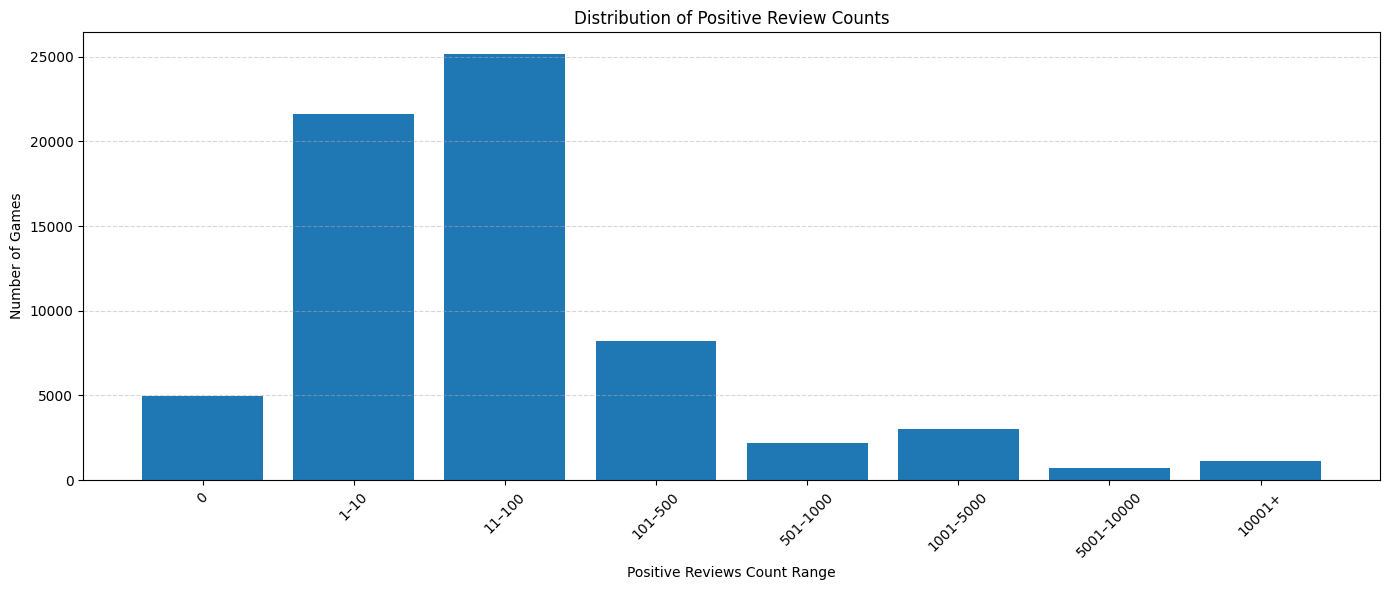

In [ ]:
bins = [0, 1, 10, 100, 500, 1000, 5000, 10000, df["positive_reviews"].max()+1]
labels = ["0",
          "1–10",
          "11–100",
          "101–500",
          "501–1000",
          "1001–5000",
          "5001–10000",
          "10001+"]

df["review_bins"] = pd.cut(df["positive_reviews"], bins=bins, labels=labels, right=False)
counts = df["review_bins"].value_counts().sort_index()

plt.figure(figsize=(14,6))
plt.bar(labels, counts.values)
plt.xlabel("Positive Reviews Count Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Positive Review Counts")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
"""df["positive_reviews"] = pd.to_numeric(df["positive_reviews"], errors="coerce").fillna(0).astype(int)

df["positive_reviews_bin"] = "Zero"

bins = [0, 10, 100, 1000, np.inf]
labels = ["Extremely Low", "Low", "Medium", "Excellent"]

mask = df["positive_reviews"] > 0
df.loc[mask, "positive_reviews_bin"] = pd.cut(
    df.loc[mask, "positive_reviews"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=False
).astype(str)

order = ["Zero"] + labels
counts = df["positive_reviews_bin"].value_counts().reindex(order, fill_value=0)
for k, v in counts.items():
    print(f"{k}: {int(v)} games")
"""

'df["positive_reviews"] = pd.to_numeric(df["positive_reviews"], errors="coerce").fillna(0).astype(int)\n\ndf["positive_reviews_bin"] = "Zero"\n\nbins = [0, 10, 100, 1000, np.inf]\nlabels = ["Extremely Low", "Low", "Medium", "Excellent"]\n\nmask = df["positive_reviews"] > 0\ndf.loc[mask, "positive_reviews_bin"] = pd.cut(\n    df.loc[mask, "positive_reviews"],\n    bins=bins,\n    labels=labels,\n    right=True,\n    include_lowest=False\n).astype(str)\n\norder = ["Zero"] + labels\ncounts = df["positive_reviews_bin"].value_counts().reindex(order, fill_value=0)\nfor k, v in counts.items():\n    print(f"{k}: {int(v)} games")\n'

In [ ]:
"""import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pr = pd.to_numeric(df["positive_reviews"], errors="coerce").fillna(0).astype(int)

bins = pd.Series("Zero", index=df.index, dtype="object")
labels = ["Extremely Low", "Low", "Medium", "Excellent"]

mask = pr > 0
bins.loc[mask] = pd.cut(
    pr.loc[mask],
    bins=[0, 10, 100, 1000, np.inf],
    labels=labels,
    right=True
).astype(str)

order = ["Zero"] + labels
counts = bins.value_counts().reindex(order, fill_value=0)

plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Positive Reviews Bin")
plt.ylabel("Number of Games")
plt.title("Positive Reviews (Binned)")
plt.tight_layout()
plt.show()"""

'import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\npr = pd.to_numeric(df["positive_reviews"], errors="coerce").fillna(0).astype(int)\n\nbins = pd.Series("Zero", index=df.index, dtype="object")\nlabels = ["Extremely Low", "Low", "Medium", "Excellent"]\n\nmask = pr > 0\nbins.loc[mask] = pd.cut(\n    pr.loc[mask],\n    bins=[0, 10, 100, 1000, np.inf],\n    labels=labels,\n    right=True\n).astype(str)\n\norder = ["Zero"] + labels\ncounts = bins.value_counts().reindex(order, fill_value=0)\n\nplt.figure(figsize=(7,4))\nplt.bar(counts.index.astype(str), counts.values)\nplt.xlabel("Positive Reviews Bin")\nplt.ylabel("Number of Games")\nplt.title("Positive Reviews (Binned)")\nplt.tight_layout()\nplt.show()'

In [ ]:
"""df = df.drop(columns=["positive_reviews", "review_bins"])"""

'df = df.drop(columns=["positive_reviews", "review_bins"])'

In [ ]:
df.to_csv("df_positive_reviews.csv", index=False)

# **Genres**

In [ ]:
genre_counts = {}

for cell in df["genres"].dropna():
    parts = cell.split(",")
    for g in parts:
        g_clean = g.strip()
        if g_clean:
            genre_counts[g_clean] = genre_counts.get(g_clean, 0) + 1

genre_df = pd.DataFrame(list(genre_counts.items()), columns=["Genre", "Count"])
genre_df = genre_df.sort_values("Count", ascending=False)

print(genre_df)


                    Genre  Count
1                   Indie  47966
0                  Casual  29440
4                  Action  27747
5               Adventure  26928
2              Simulation  14014
10               Strategy  13407
7                     RPG  12567
8            Early Access   6842
9            Free To Play   6690
3                  Sports   2815
6                  Racing   2477
11  Massively Multiplayer   1586
17                Violent    304
18                   Gore    189
19                 Nudity     72
20         Sexual Content     70
14              Education     24
13       Game Development     17
21              Utilities     12
12  Design & Illustration     11
16   Animation & Modeling     10
15      Software Training     10
22       Audio Production      7
23             Accounting      3
24         Web Publishing      3
26       Video Production      3
25          Photo Editing      1


In [ ]:
genre_columns = {
    "Indie": "isIndie",
    "Casual": "isCasual",
    "Action": "isAction",
    "Adventure": "isAdventure",
    "Simulation": "isSimulation",
    "Strategy": "isStrategy",
    "RPG": "isRPG",
    "Early Access": "isEarlyAccess",
    "Free To Play": "isFTP",
    "Sports": "isSports",
    "Racing": "isRacing",
    "Massively Multiplayer": "isMM",
    "Violent": "isViolent",
    "Gore": "isGore",
    "Nudity": "isNudity",
    "Sexual Content": "isSexualContent",
    "Education": "isEducation",
    "Game Development": "isGameDevelopment",
    "Utilities": "isUtilities",
    "Design & Illustration": "isDesignIllustration",
    "Animation & Modeling": "isAnimationModeling",
    "Software Training": "isSoftwareTraining",
    "Audio Production": "isAudioProduction",
    "Accounting": "isAccounting",
    "Web Publishing": "isWebPublishing",
    "Video Production": "isVideoProduction",
    "Photo Editing": "isPhotoEditing"
}

df["genres_list"] = df["genres"].fillna("").apply(lambda x: [g.strip() for g in x.split(",") if g.strip()])

for genre, col_name in genre_columns.items():
    df[col_name] = df["genres_list"].apply(lambda lst: genre in lst)

df = df.drop(columns=["genres_list"])

In [ ]:
df = df.drop(columns=["genres"])

In [ ]:
df["isAdultContent"] = (
    df["isNudity"] | df["isSexualContent"]
)

In [ ]:
other_apps_cols = [
    "isEducation",
    "isGameDevelopment",
    "isUtilities",
    "isDesignIllustration",
    "isAnimationModeling",
    "isSoftwareTraining",
    "isAudioProduction",
    "isAccounting",
    "isWebPublishing",
    "isVideoProduction",
    "isPhotoEditing"
]

df["isOtherApps"] = df[other_apps_cols].any(axis=1)

In [ ]:
df = df.drop(columns=[
    "isNudity",
    "isSexualContent",
    "isEducation",
    "isGameDevelopment",
    "isUtilities",
    "isDesignIllustration",
    "isAnimationModeling",
    "isSoftwareTraining",
    "isAudioProduction",
    "isAccounting",
    "isWebPublishing",
    "isVideoProduction",
    "isPhotoEditing"
])

In [ ]:
print(df[["isAdultContent", "isOtherApps"]].sum())

isAdultContent    104
isOtherApps        61
dtype: int64


In [ ]:
df.to_csv("df_genres_boolean.csv", index=False)

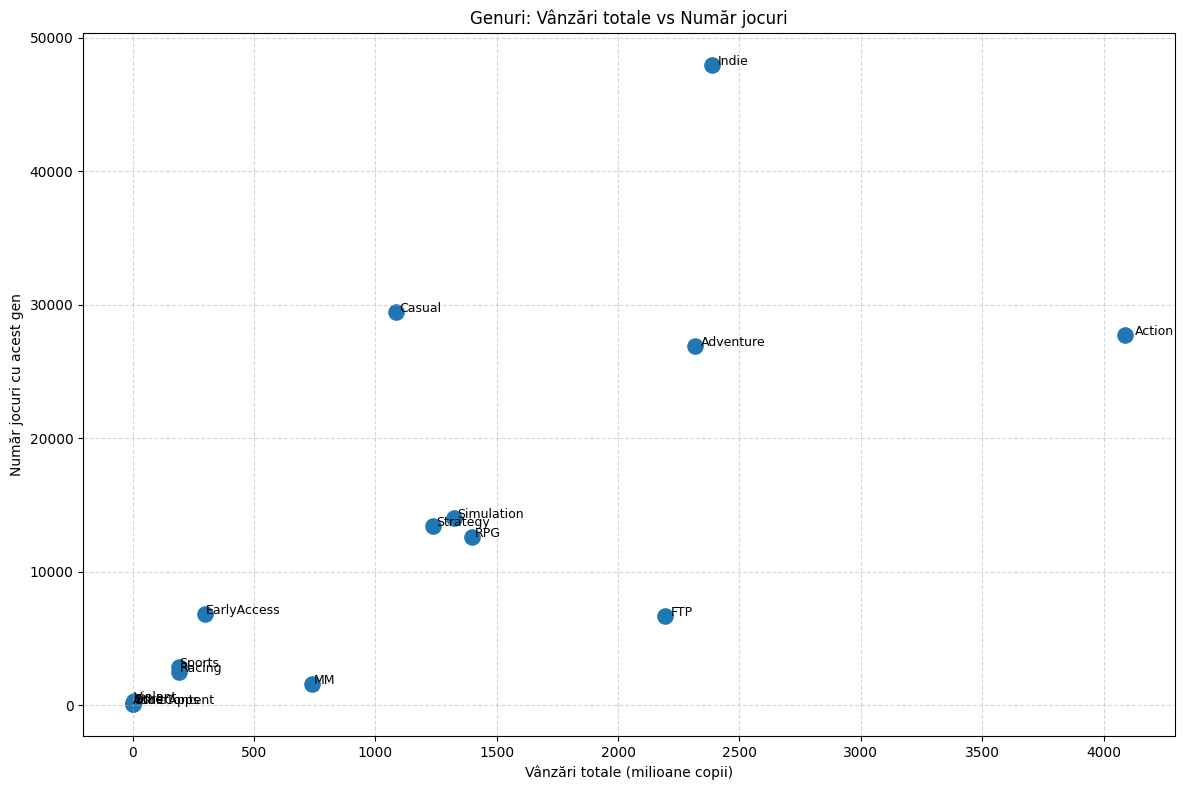

In [ ]:
df = pd.read_csv("df_genres_boolean.csv", low_memory=False)

genre_cols = [col for col in df.columns if col.startswith("is")]

total_sales = (df[genre_cols].T.dot(df["copiesSold"].fillna(0))) / 1_000_000

game_counts = df[genre_cols].sum()

plot_df = pd.DataFrame({
    "Genre": genre_cols,
    "TotalSales_M": total_sales.values,
    "GameCount": game_counts.values
})

plt.figure(figsize=(12,8))
plt.scatter(plot_df["TotalSales_M"], plot_df["GameCount"], s=120)

for i in range(plot_df.shape[0]):
    plt.text(
        plot_df["TotalSales_M"].iloc[i] * 1.01,
        plot_df["GameCount"].iloc[i],
        plot_df["Genre"].iloc[i].replace("is", ""),
        fontsize=9
    )

plt.xlabel("Vânzări totale (milioane copii)")
plt.ylabel("Număr jocuri cu acest gen")
plt.title("Genuri: Vânzări totale vs Număr jocuri")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **Languages**

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("df_genres_boolean.csv", low_memory=False)

In [ ]:
import ast
import numpy as np
import re

def _extract_with_regex(text):
    pattern = r"'((?:\\'|[^'])*)'|\"((?:\\\"|[^\"])*)\""
    matches = re.findall(pattern, text)
    items = []
    for g1, g2 in matches:
        token = g1 if g1 != "" else g2
        token = token.replace("\\'", "'").replace('\\"', '"').replace("\\\\", "\\")
        items.append(token)
    return items


def clean_languages(value):
    if pd.isna(value):
        return np.nan

    text = str(value).strip()

    if text in ["['[]']", "['nan']", "[]", "['']"]:
        return np.nan

    parsed = None

    try:
        parsed = ast.literal_eval(text)
    except Exception:
        parsed = None

    if isinstance(parsed, list) and len(parsed) == 1 and isinstance(parsed[0], str):
        inner = parsed[0].strip()
        if inner.startswith("[") and inner.endswith("]"):
            try:
                parsed_inner = ast.literal_eval(inner)
                parsed = parsed_inner
            except Exception:
                try:
                    parsed_inner = ast.literal_eval(inner.replace("\\'", "'").replace('\\"', '"'))
                    parsed = parsed_inner
                except Exception:
                    parsed = _extract_with_regex(inner)

    if isinstance(parsed, list):
        flat = []
        for item in parsed:
            if isinstance(item, list):
                flat.extend(item)
            else:
                flat.append(item)
    else:
        flat = _extract_with_regex(text)

    split_items = []
    for item in flat:
        if item is None:
            continue

        s = str(item).strip()
        if s == "" or s.lower() == "nan":
            continue

        if ";" in s:
            semi_split = [x.strip() for x in s.split(";") if x.strip() != ""]
            split_items.extend(semi_split)
        else:
            split_items.append(s)

    if len(split_items) == 0:
        return np.nan

    return ", ".join(split_items)


In [ ]:
df["languages_clean"] = df["languages"].apply(clean_languages)

In [ ]:
df.to_csv("df_languages_cleaned.csv", index=False)

In [ ]:
lang_series = df["languages_clean"].dropna().astype(str)

all_languages = lang_series.str.split(", ").explode()

all_languages = all_languages.str.strip().str.lower()

invalid = ["", "nan", "none", "0"]
all_languages = all_languages[~all_languages.isin(invalid)]

language_counts = all_languages.value_counts()

print("-" * 50)
print(f"Lista completă a {language_counts.shape[0]} limbilor unice (sortate după frecvență):")
print("-" * 50)
print(language_counts.to_string())


--------------------------------------------------
Lista completă a 109 limbilor unice (sortate după frecvență):
--------------------------------------------------
languages_clean
english                                                         63052
simplified chinese                                              17700
german                                                          16518
french                                                          16245
japanese                                                        15177
spanish - spain                                                 15146
russian                                                         14996
italian                                                         11316
korean                                                           9869
portuguese - brazil                                              9306
traditional chinese                                              8957
polish                                            

In [ ]:
import pandas as pd

df = pd.read_csv("df_languages_cleaned.csv", low_memory=False)

lang_mapping = {
    "english": "langEN",
    "simplified chinese": "langZHs",
    "german": "langDE",
    "french": "langFR",
    "japanese": "langJA",
    "spanish - spain": "langESes",
    "russian": "langRU",
    "italian": "langIT",
    "korean": "langKO",
    "portuguese - brazil": "langPTbr",
    "traditional chinese": "langZHt",
    "polish": "langPL",
    "portuguese - portugal": "langPTpt",
    "turkish": "langTR",
    "spanish - latin america": "langESla",
    "dutch": "langNL",
    "ukrainian": "langUK",
    "czech": "langCS",
    "swedish": "langSV",
    "hungarian": "langHU",
    "thai": "langTH",
    "arabic": "langAR",
    "danish": "langDA",
    "norwegian": "langNO",
    "finnish": "langFI",
    "romanian": "langRO",
    "greek": "langEL",
    "vietnamese": "langVI",
    "bulgarian": "langBG",
    "indonesian": "langID",
    "hindi": "langHI",
    "catalan": "langCA",
    "slovak": "langSK",
    "serbian": "langSR",
    "hebrew": "langHE",
    "malay": "langMS",
    "croatian": "langHR",
    "belarusian": "langBE",
    "lithuanian": "langLT",
    "filipino": "langTL",
    "basque": "langEU",
    "persian": "langFA",
    "latvian": "langLV",
    "estonian": "langET",
    "icelandic": "langIS",
    "slovenian": "langSL",
    "galician": "langGL",
    "afrikaans": "langAF",
    "bangla": "langBN",
    "welsh": "langCY",
    "georgian": "langKA",
    "azerbaijani": "langAZ",
    "urdu": "langUR",
    "bosnian": "langBS",
    "kazakh": "langKK",
    "albanian": "langSQ",
    "irish": "langGA",
    "macedonian": "langMK",
    "uzbek": "langUZ",
    "mongolian": "langMN",
    "swahili": "langSW",
    "tamil": "langTA",
    "gujarati": "langGU",
    "punjabi (gurmukhi)": "langPA",
    "kyrgyz": "langKY",
    "luxembourgish": "langLB",
    "zulu": "langZU",
    "telugu": "langTE",
    "armenian": "langHY",
    "tatar": "langTT",
    "tajik": "langTG",
    "maori": "langMI",
    "kinyarwanda": "langRW",
    "nepali": "langNE",
    "malayalam": "langML",
    "maltese": "langMT",
    "marathi": "langMR",
    "scots": "langGD",
    "uyghur": "langUG",
    "hausa": "langHA",
    "sinhala": "langSI",
    "xhosa": "langXH",
    "yoruba": "langYO",
    "kannada": "langKN",
    "igbo": "langIG",
    "turkmen": "langTK",
    "sindhi": "langSD",
    "punjabi (shahmukhi)": "langPS",
    "odia": "langOR",
    "sotho": "langST",
    "konkani": "langKOK",
    "assamese": "langAS",
    "amharic": "langAM",
    "khmer": "langKM",
    "quechua": "langQU",
    "sorani": "langKU",
    "tswana": "langTN",
    "tigrinya": "langTI",
    "dari": "langDAri",
    "cherokee": "langCHR",
    "valencian": "langCAval",
    "wolof": "langWO",
    "k'iche'": "langKICHE",
    "#lang_slovakian": "langSK_special",
    "#lang_#lang_russian*#lang_full_audio": "langRU_audio",
    "#lang_#lang_#lang_english**#lang_full_audio*#lang_full_audio": "langEN_audio",
    "#lang_#lang_spanish*#lang_full_audio": "langES_audio",
    "#lang_german": "langDE_audio",
    "(all with full audio support)": "lang_audio"
}

bool_cols = {}

for original, new_col in lang_mapping.items():
    bool_cols[new_col] = df["languages_clean"].fillna("").str.lower().str.contains(original.lower(), regex=False)

df = pd.concat([df, pd.DataFrame(bool_cols)], axis=1)

df.to_csv("df_languages_boolean.csv", index=False)
print("Saved df_languages_boolean.csv with all boolean language columns.")

Saved df_languages_boolean.csv with all boolean language columns.


In [ ]:
def merge_into(target_col, source_col):
    if source_col in df.columns:
        if target_col not in df.columns:
            df[target_col] = False
        df[target_col] = df[target_col].astype(bool) | df[source_col].astype(bool)
        df.drop(columns=[source_col], inplace=True)

merge_into("langSK", "#lang_slovakian")
merge_into("langDE", "#lang_german")
merge_into("langRU", "#lang_#lang_russian*#lang_full_audio")
merge_into("langEN", "#lang_#lang_#lang_english**#lang_full_audio*#lang_full_audio")
if "#lang_#lang_spanish*#lang_full_audio" in df.columns:
    merge_into("langESes", "#lang_#lang_spanish*#lang_full_audio")
    if "langESla" in df.columns:
        df["langESla"] = df["langESla"].astype(bool) | df["langESes"].astype(bool)

merge_into("langSK", "langSK_special")
merge_into("langRU", "langRU_audio")
merge_into("langEN", "langEN_audio")
if "langES_audio" in df.columns:
    merge_into("langESes", "langES_audio")
    if "langESla" in df.columns:
        df["langESla"] = df["langESla"].astype(bool) | df["langESes"].astype(bool)
merge_into("langDE", "langDE_audio")

for col in ["lang_audio", "(all with full audio support)"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

df.to_csv("df_languages_boolean.csv", index=False)
print("Updated df_languages_boolean.csv: outliers merged + audio-only column removed.")


Updated df_languages_boolean.csv: outliers merged + audio-only column removed.


In [ ]:
df.info(200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67031 entries, 0 to 67030
Data columns (total 141 columns):
 #    Column               Dtype  
---   ------               -----  
 0    appid                int64  
 1    name                 object 
 2    steam_trading_cards  bool   
 3    workshop_support     bool   
 4    achievements_total   float64
 5    has_dlc              bool   
 6    has_demo             bool   
 7    price                float64
 8    copiesSold           int64  
 9    publisherClass       object 
 10   languages            object 
 11   positive_reviews     int64  
 12   metacritic_category  object 
 13   achievements_bin     object 
 14   release_parsed       object 
 15   date_bins            object 
 16   hasWindows           bool   
 17   hasMac               bool   
 18   hasLinux             bool   
 19   reviewScore_bin      object 
 20   review_bins          object 
 21   isIndie              bool   
 22   isCasual             bool   
 23   isAction 

In [ ]:
cols_to_drop = [
    "languages",
    "languages_clean",
    "release_parsed",
]

df = df.drop(columns=cols_to_drop)

In [ ]:
df.to_csv("df_languages_boolean_final.csv", index=False)

# **Copies Sold**

In [ ]:
df = pd.read_csv("df_languages_boolean_final.csv", low_memory=False)

copies_numeric = pd.to_numeric(df["copiesSold"], errors="coerce")

invalid = df[
    (copies_numeric.isna()) |
    (copies_numeric < 0) |
    (copies_numeric % 1 != 0)
]

print("Number of invalid copiesSold entries:", len(invalid))
print(invalid[["appid", "name", "copiesSold"]].head(20))


Number of invalid copiesSold entries: 0
Empty DataFrame
Columns: [appid, name, copiesSold]
Index: []


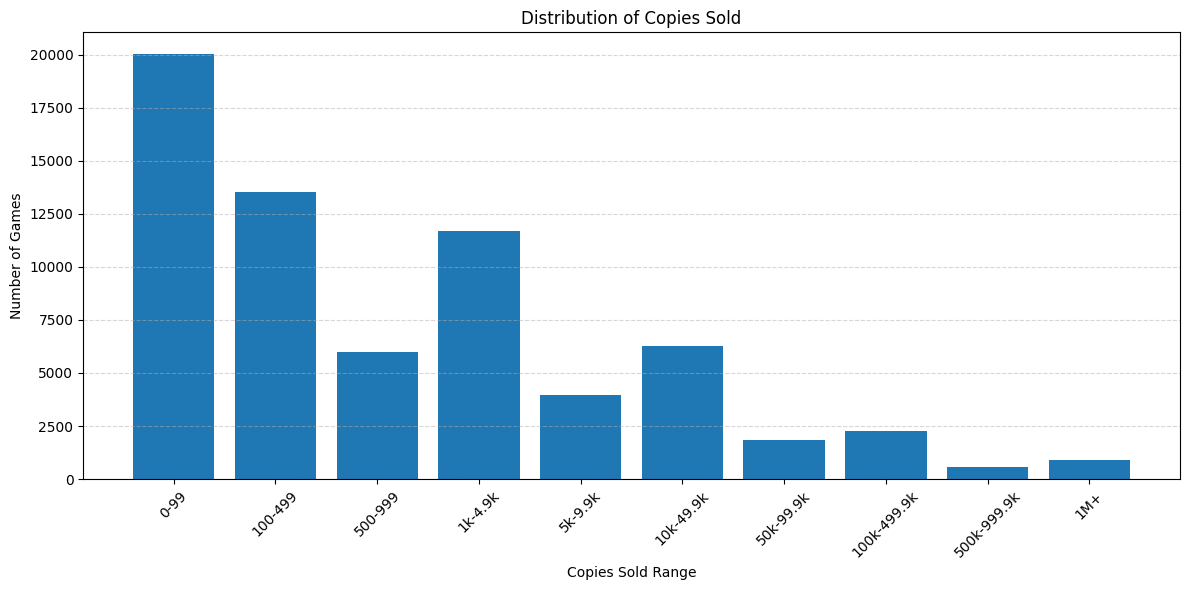

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv("df_languages_boolean_final.csv", low_memory=False)

copies = pd.to_numeric(df["copiesSold"], errors="coerce").fillna(0).astype(int)

bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, copies.max()+1]
labels = ["0-99","100-499","500-999","1k-4.9k","5k-9.9k","10k-49.9k",
          "50k-99.9k","100k-499.9k","500k-999.9k","1M+"]

copies_binned = pd.cut(copies, bins=bins, labels=labels, right=False)
counts = copies_binned.value_counts().sort_index()

plt.figure(figsize=(12,6))
plt.bar(labels, counts.values, color="#1f77b4")
plt.xlabel("Copies Sold Range")
plt.ylabel("Number of Games")
plt.title("Distribution of Copies Sold")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("df_languages_boolean_final.csv", low_memory=False)

cols = [col for col in df.columns if col != "copiesSold"] + ["copiesSold"]
df = df[cols]

df.to_csv("df_final_v2.csv", index=False)
print("Saved df_final_v2.csv with copiesSold as the last column.")

Saved df_final_v2.csv with copiesSold as the last column.


In [ ]:
df = df.drop(columns=["achievements_total"])

In [ ]:
df = df.drop(columns=["review_bins"])

In [ ]:
df.info(200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67031 entries, 0 to 67030
Data columns (total 136 columns):
 #    Column               Dtype  
---   ------               -----  
 0    appid                int64  
 1    name                 object 
 2    steam_trading_cards  bool   
 3    workshop_support     bool   
 4    has_dlc              bool   
 5    has_demo             bool   
 6    price                float64
 7    publisherClass       object 
 8    positive_reviews     int64  
 9    metacritic_category  object 
 10   achievements_bin     object 
 11   date_bins            object 
 12   hasWindows           bool   
 13   hasMac               bool   
 14   hasLinux             bool   
 15   reviewScore_bin      object 
 16   isIndie              bool   
 17   isCasual             bool   
 18   isAction             bool   
 19   isAdventure          bool   
 20   isSimulation         bool   
 21   isStrategy           bool   
 22   isRPG                bool   
 23   isEarlyAc

In [ ]:
df.to_csv("df_final_v3.csv", index=False)

Am mutat coloana copiesSold sa fie ultima.

In [ ]:
print("Missing values (NaN) in entire file:", int(df.isna().sum().sum()))

Missing values (NaN) in entire file: 0
